In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
from dataset import ASODataset
from graph_fn import onehot_everything
from trainer import Trainer
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
import torch
from torch_geometric.loader import DataLoader
from models import *

In [3]:
#hyperparameters
LEARNING_RATE = 7.5e-3
BATCH_SIZE = 16
EPOCHS = 50
DROP_OUT = 0.05
INPUT_SIZE = 53
OUTPUT_SIZE = 1
HIDDEN_SIZE = 50

Run 1
Epoch: 050, Train Loss: 0.4464, Test Loss: 0.4655, Train MAE: 0.0319, Test MAE: 0.0314, , Train R2: 0.9027, Test R2: 0.8863
Run 2
Epoch: 050, Train Loss: 0.4479, Test Loss: 0.4512, Train MAE: 0.0309, Test MAE: 0.0403, , Train R2: 0.9073, Test R2: 0.8742
Run 3
Epoch: 050, Train Loss: 0.4509, Test Loss: 0.4241, Train MAE: 0.0320, Test MAE: 0.0296, , Train R2: 0.9009, Test R2: 0.9059
Run 4
Epoch: 050, Train Loss: 0.4483, Test Loss: 0.4419, Train MAE: 0.0304, Test MAE: 0.0321, , Train R2: 0.9156, Test R2: 0.9055
Run 5
Epoch: 050, Train Loss: 0.4466, Test Loss: 0.4671, Train MAE: 0.0325, Test MAE: 0.0390, , Train R2: 0.8925, Test R2: 0.8800
0.03143628165125847 0.03421950861811638


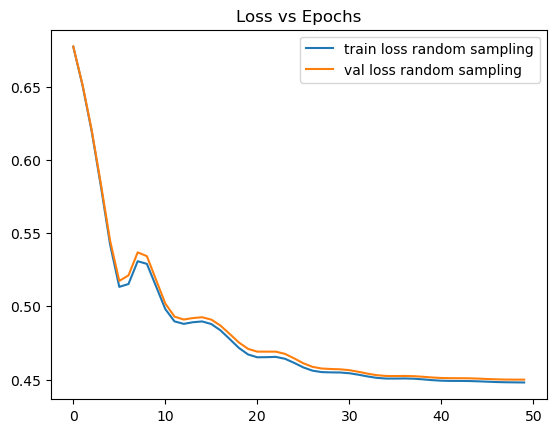

In [37]:
import numpy as np

train_loss = 0
test_loss = 0
train_MAE = 0
test_MAE = 0

NUM_RUN = 5

for i in range(NUM_RUN):
    print("Run " + str(i + 1))

    a = ASODataset(onehot_everything,no_graph=True)
    X_train, X_val, y_train, y_val = train_test_split(a.data[0], a.data[1], test_size=0.1)

    device = torch.device('cuda')
    model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, 3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    t = Trainer(model, device, optimizer, scheduler, glob_v= False, no_graph = True)
    results = t.train_no_graph(torch.tensor(X_train, dtype=torch.float), torch.tensor(X_val, dtype=torch.float), torch.tensor(y_train, dtype=torch.float), torch.tensor(y_val, dtype=torch.float), nn.BCELoss, EPOCHS, silent = True)
    
    train_loss += np.array(t.log["train_loss"])
    test_loss += np.array(t.log["val_loss"])

    train_MAE += results[1]
    test_MAE += results[4]

train_loss /= NUM_RUN
test_loss /= NUM_RUN
train_MAE /= NUM_RUN
test_MAE /= NUM_RUN

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title("Loss vs Epochs")
plt.plot(train_loss, label="train loss random sampling")
plt.plot(test_loss, label = "val loss random sampling")
plt.legend()

rs_train = train_loss
rs_test = test_loss

print(train_MAE, test_MAE)

Run 1
Epoch: 050, Train Loss: 0.4589, Test Loss: 0.4641, Train MAE: 0.0326, Test MAE: 0.1166, , Train R2: 0.9042, Test R2: -0.1434
Run 2
Epoch: 050, Train Loss: 0.4429, Test Loss: 0.5198, Train MAE: 0.0328, Test MAE: 0.1135, , Train R2: 0.8953, Test R2: 0.0974
Run 3
Epoch: 050, Train Loss: 0.4461, Test Loss: 0.4885, Train MAE: 0.0337, Test MAE: 0.0942, , Train R2: 0.8972, Test R2: 0.1680
Run 4
Epoch: 050, Train Loss: 0.4653, Test Loss: 0.4759, Train MAE: 0.0330, Test MAE: 0.1492, , Train R2: 0.8939, Test R2: -0.0514
Run 5
Epoch: 050, Train Loss: 0.4193, Test Loss: 0.6278, Train MAE: 0.0338, Test MAE: 0.1495, , Train R2: 0.8681, Test R2: -0.1353


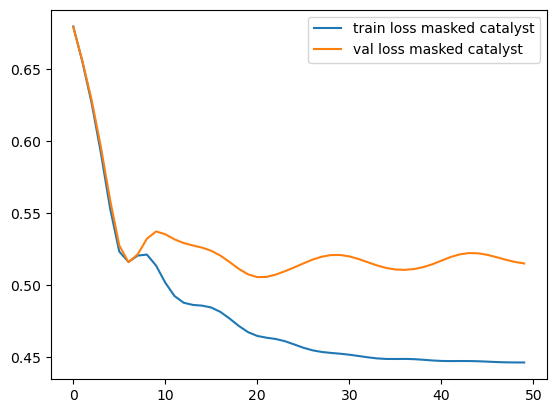

0.03273906707763672 0.0993156224489212


In [41]:
import numpy as np

train_loss = 0
train_loss_max = float("-inf")
train_loss_min = float("inf")
test_loss = 0
test_loss_max = float("-inf")
test_loss_min = float("inf")
train_MAE = 0
test_MAE = 0

NUM_RUN = 5

for i in range(NUM_RUN):
    print("Run " + str(i + 1))

    a = ASODataset(onehot_everything, no_graph=True)
    X_train, X_val, y_train, y_val = a.sample_test_data_catalyst_only(10,2,2)

    device = torch.device('cuda')
    model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, 3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    t = Trainer(model, device, optimizer, scheduler, glob_v= False, no_graph = True)
    results = t.train_no_graph(torch.tensor(X_train, dtype=torch.float), torch.tensor(X_val, dtype=torch.float), torch.tensor(y_train, dtype=torch.float), torch.tensor(y_val, dtype=torch.float), nn.BCELoss, EPOCHS, silent = True)
    
    train_loss += np.array(t.log["train_loss"])
    train_loss_max = np.maximum(train_loss_max, np.array(t.log["train_loss"]))
    train_loss_min = np.minimum(train_loss_min, np.array(t.log["train_loss"]))

    test_loss += np.array(t.log["val_loss"])
    test_loss_max = np.maximum(test_loss_max, np.array(t.log["val_loss"]))
    test_loss_min = np.minimum(test_loss_min, np.array(t.log["val_loss"]))

    train_MAE += results[1]
    test_MAE += results[4]

train_loss /= NUM_RUN
test_loss /= NUM_RUN
train_MAE /= NUM_RUN
test_MAE /= NUM_RUN

mc_train = train_loss
mc_test = test_loss

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss, label="train loss masked catalyst")
plt.plot(test_loss, label = "val loss masked catalyst")
#plt.fill_between(np.arange(len(train_loss)), train_loss_max, train_loss_min, alpha=0.5,)
#plt.fill_between(np.arange(len(test_loss)), test_loss_max, test_loss_min, alpha=0.5,)
plt.legend()
plt.show()

print(train_MAE, test_MAE)

Run 1
Epoch: 050, Train Loss: 0.4962, Test Loss: 0.4466, Train MAE: 0.0378, Test MAE: 0.1400, , Train R2: 0.8726, Test R2: -0.2808
Run 2
Epoch: 050, Train Loss: 0.4305, Test Loss: 0.4992, Train MAE: 0.0278, Test MAE: 0.0836, , Train R2: 0.9212, Test R2: 0.6264
Run 3
Epoch: 050, Train Loss: 0.4402, Test Loss: 0.4769, Train MAE: 0.0328, Test MAE: 0.0724, , Train R2: 0.9111, Test R2: 0.6681
Run 4
Epoch: 050, Train Loss: 0.4279, Test Loss: 0.5045, Train MAE: 0.0261, Test MAE: 0.0846, , Train R2: 0.9342, Test R2: 0.6191
Run 5
Epoch: 050, Train Loss: 0.4432, Test Loss: 0.4854, Train MAE: 0.0290, Test MAE: 0.0799, , Train R2: 0.9197, Test R2: 0.6134


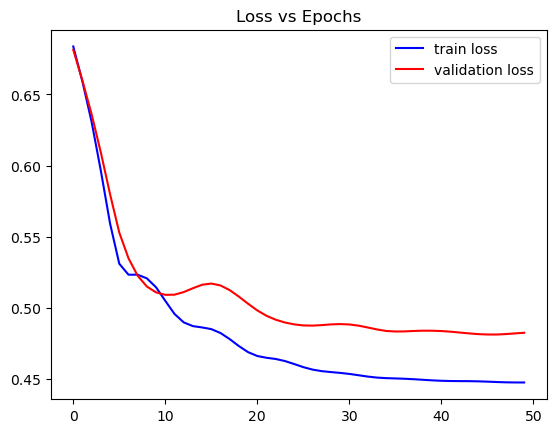

0.030288854241371156 0.08893968164920807


In [48]:
import numpy as np

train_loss = 0
test_loss = 0
train_MAE = 0
test_MAE = 0

NUM_RUN = 5

for i in range(NUM_RUN):
    print("Run " + str(i + 1))

    a = ASODataset(onehot_everything, no_graph=True)
    X_train, X_val, y_train, y_val = a.sample_test_data_reactant_only(10,2,2)

    device = torch.device('cuda')
    model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, 3, dp_rate=DROP_OUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    t = Trainer(model, device, optimizer, scheduler, glob_v= False, no_graph = True)
    results = t.train_no_graph(torch.tensor(X_train, dtype=torch.float), torch.tensor(X_val, dtype=torch.float), torch.tensor(y_train, dtype=torch.float), torch.tensor(y_val, dtype=torch.float), nn.BCELoss, EPOCHS, silent = True)
    
    train_loss += np.array(t.log["train_loss"])
    test_loss += np.array(t.log["val_loss"])

    train_MAE += results[1]
    test_MAE += results[4]

train_loss /= NUM_RUN
test_loss /= NUM_RUN
train_MAE /= NUM_RUN
test_MAE /= NUM_RUN

mr_train = train_loss
mr_test = test_loss

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.title("Loss vs Epochs")
plt.plot(train_loss, '-b', label="train loss")
plt.plot(test_loss, '-r', label = "validation loss")
plt.legend()
plt.show()

print(train_MAE, test_MAE)

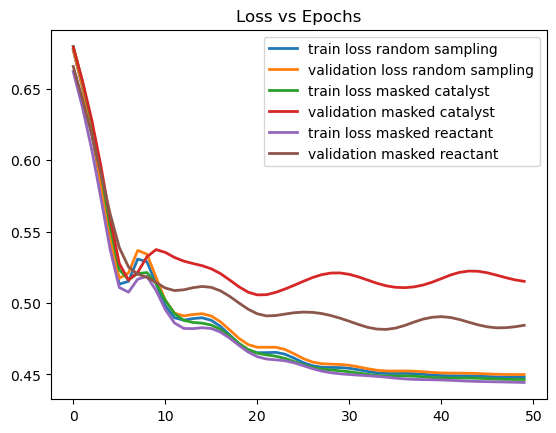

In [46]:
plt.figure()
plt.title("Loss vs Epochs For All One-hot Encodings")
plt.plot(rs_train, label="train loss random sampling", linewidth=2)
plt.plot(rs_test, label = "validation loss random sampling", linewidth=2)
plt.plot(mc_train, label="train loss masked catalyst", linewidth=2)
plt.plot(mc_test, label = "validation masked catalyst", linewidth=2)
plt.plot(mr_train, label="train loss masked reactant", linewidth=2)
plt.plot(mr_test, label = "validation masked reactant", linewidth=2)
plt.legend()
plt.show()

In [51]:
mc_test.tofile('oh_mc_test.csv', sep=',')
mr_test.tofile('oh_mr_test.csv', sep=',')

In [52]:
rs_train.tofile('oh_rs_train.csv', sep=',')
rs_test.tofile('oh_rs_test.csv', sep=',')